<a href="https://colab.research.google.com/github/con11235/covid19_visualize/blob/master/markdown/%EC%8A%B9%ED%98%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part.0. 분석의 목적 및 흐름
안녕하세요, 팀 클릭입니다. 코로나 발생 이후 사회에 생긴 변화는 새로운 소비 트렌드가 등장했다는 점입니다. 우리는 이와 관련한 데이터를 분석하고 파악함으로써 이러한 트렌드를 가장 적극적으로 반영할 수 있는 산업이 무엇인지를 찾고자 합니다.  
 
코로나로 인해 생긴 가장 큰 변화를 떠올려보면 다음과 같은 두 특징이 있습니다.  
 
첫 번째, 코로나로 인해 발생한 여러 소비 트렌드들로 인해 사람들이 주로 소비하는 산업 자체가 달라졌다는 점입니다.  
![코로나19와 5대 소비 트렌드 이미지](https://i.ibb.co/VVfwcS0/1.png)  
집에서 보내는 시간의 증가로 집 안에서의 다양한 의식주 라이프스타일과 여가생활을 추구하는 '홈코노미', 인간 본원적 가치를 중시하는 현상으로 인해 불안감 및 두려움 등의 심리를 위안하는 '불안케어', 나를 위한 자기중심적 소비인 '에고이즘' 등이 대표적인 예입니다[(참고 기사)](http://m.joseilbo.com/news/view.htm?newsid=402010#_enliple). 우리는 소비 트렌드의 변화로 영향을 받았을 산업을 찾고자 하였고, 이를 위해 카드 소비 데이터를 분석하기로 하였습니다.  
 
두 번째, 대면 접촉이 꺼려짐으로 인해 비대면 방식의 생활이 확산되었습니다. 우리가 이러한 비대면 생활에 쉽게 적응될 수 있었던 것은 스마트폰이나 인터넷의 힘이 큽니다. 이로 미루어 보아, 사람들이 코로나 이후로 관심이 높아진 산업이 무엇인지를 찾기 위한 답은 스마트폰 안에 있을 것입니다. 우리는 이를 찾기 위해 스마트폰 앱의 순위 데이터를 장르별로 분석하기로 하였습니다.

즉, 우리는 코로나로 인한 소비 및 흥미의 변화를 파악하여 트렌드가 반영된 유망 산업을 찾는 방식으로 데이터를 분석해보았습니다.  
 
이후의 설명에는 필수적인 코드와 결과만을 포함하며 전체 코드에 대한 정보는 [깃허브 링크](https://github.com/con11235/covid19_visualize)에서 확인할 수 있습니다.

# Part.1. 코로나 확진자 데이터의 분석  




In [83]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath, size=9).get_name()
plt.rc('font', family=font_name) 
fm._rebuild()

import datetime
import plotly.express as px

import plotly
from plotly.graph_objs import Scatter, Line, Layout
 
import importlib
import json
 
from plotly.subplots import make_subplots
import plotly.graph_objects as go


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
case=pd.read_csv('/content/gdrive/My Drive/dacon/COVID_19/Time.csv',usecols=['date','confirmed'])
case=case.sort_values(['date'],ascending=False)
case=case.reset_index()
case=case.drop(['index'],axis=1)

d_c=[]
for i in range(len(case)-1):
    d_c.append(case['confirmed'][i]-case['confirmed'][i+1])
d_c.append(1)

case['daily']=d_c
case=case.sort_values(['date'],ascending=True)
case=case.reset_index()
case=case.drop(['index'],axis=1)

In [4]:
patientinfo=pd.read_csv('/content/gdrive/My Drive/dacon/COVID_19/PatientInfo.csv')
patientinfo.head(3)

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,서울,강서구,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,서울,중랑구,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,서울,종로구,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released


In [5]:
patientinfo_seoul=patientinfo[patientinfo['province']=='서울']

In [6]:
patient_s=patientinfo_seoul[['confirmed_date','province','infection_case']]
patient_s['cnt']=1
patient_s=patient_s.groupby(['confirmed_date','province'],as_index=False).cnt.sum()
patient_s['cnt_sum']=patient_s.groupby('province')['cnt'].cumsum()

In [7]:
patient_s['confirmed_date']=pd.to_datetime(patient_s['confirmed_date'])

In [8]:
patient_s['주차']=patient_s['confirmed_date'].dt.weekofyear
patient_s['월']=patient_s['confirmed_date'].dt.month

patient_s['월'] = patient_s['월'].apply(lambda x:f'{x}월')
patient_s['주차'] = patient_s['주차'].apply(lambda x:f'{x}주차')

우선 전국적으로 코로나 자체의 발생 동향을 파악하기 위해 코로나 확진자 수의 추이 그래프를 그려보았습니다.  
2월 중순에서 말 사이에 확진자수가 점차 증가하기 시작하였으며 3월에 최고점을 찍고, 사회적 거리두기 캠페인이 진행되었던 4월중에 코로나 확진자 수가 줄다가 캠페인이 종료된 시점의 1~2주(잠복기) 이후 다시 증가하여 그 수가 일정선을 유지하고 있음을 알 수 있습니다.

In [9]:
fig=px.bar(case,x='date',y='daily')
fig.update_layout(
    title={
        'text': "확진자 추이(전국)",
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

주어진 데이터 내에 한계가 있다보니 우리는 분석 대상을 서울시로 한정지어야한다고 생각하였고, 그렇게 분석하는게 타당할지 전국 데이터와 비교해보았습니다.  
서울시의 누적확진자 수 그래프를 보면 확진자 수가 급증하는 시점이 전국 그래프와 유사한 것을 알 수 있었고, 우리는 분석 대상을 서울시로 한정짓기로 하였습니다.

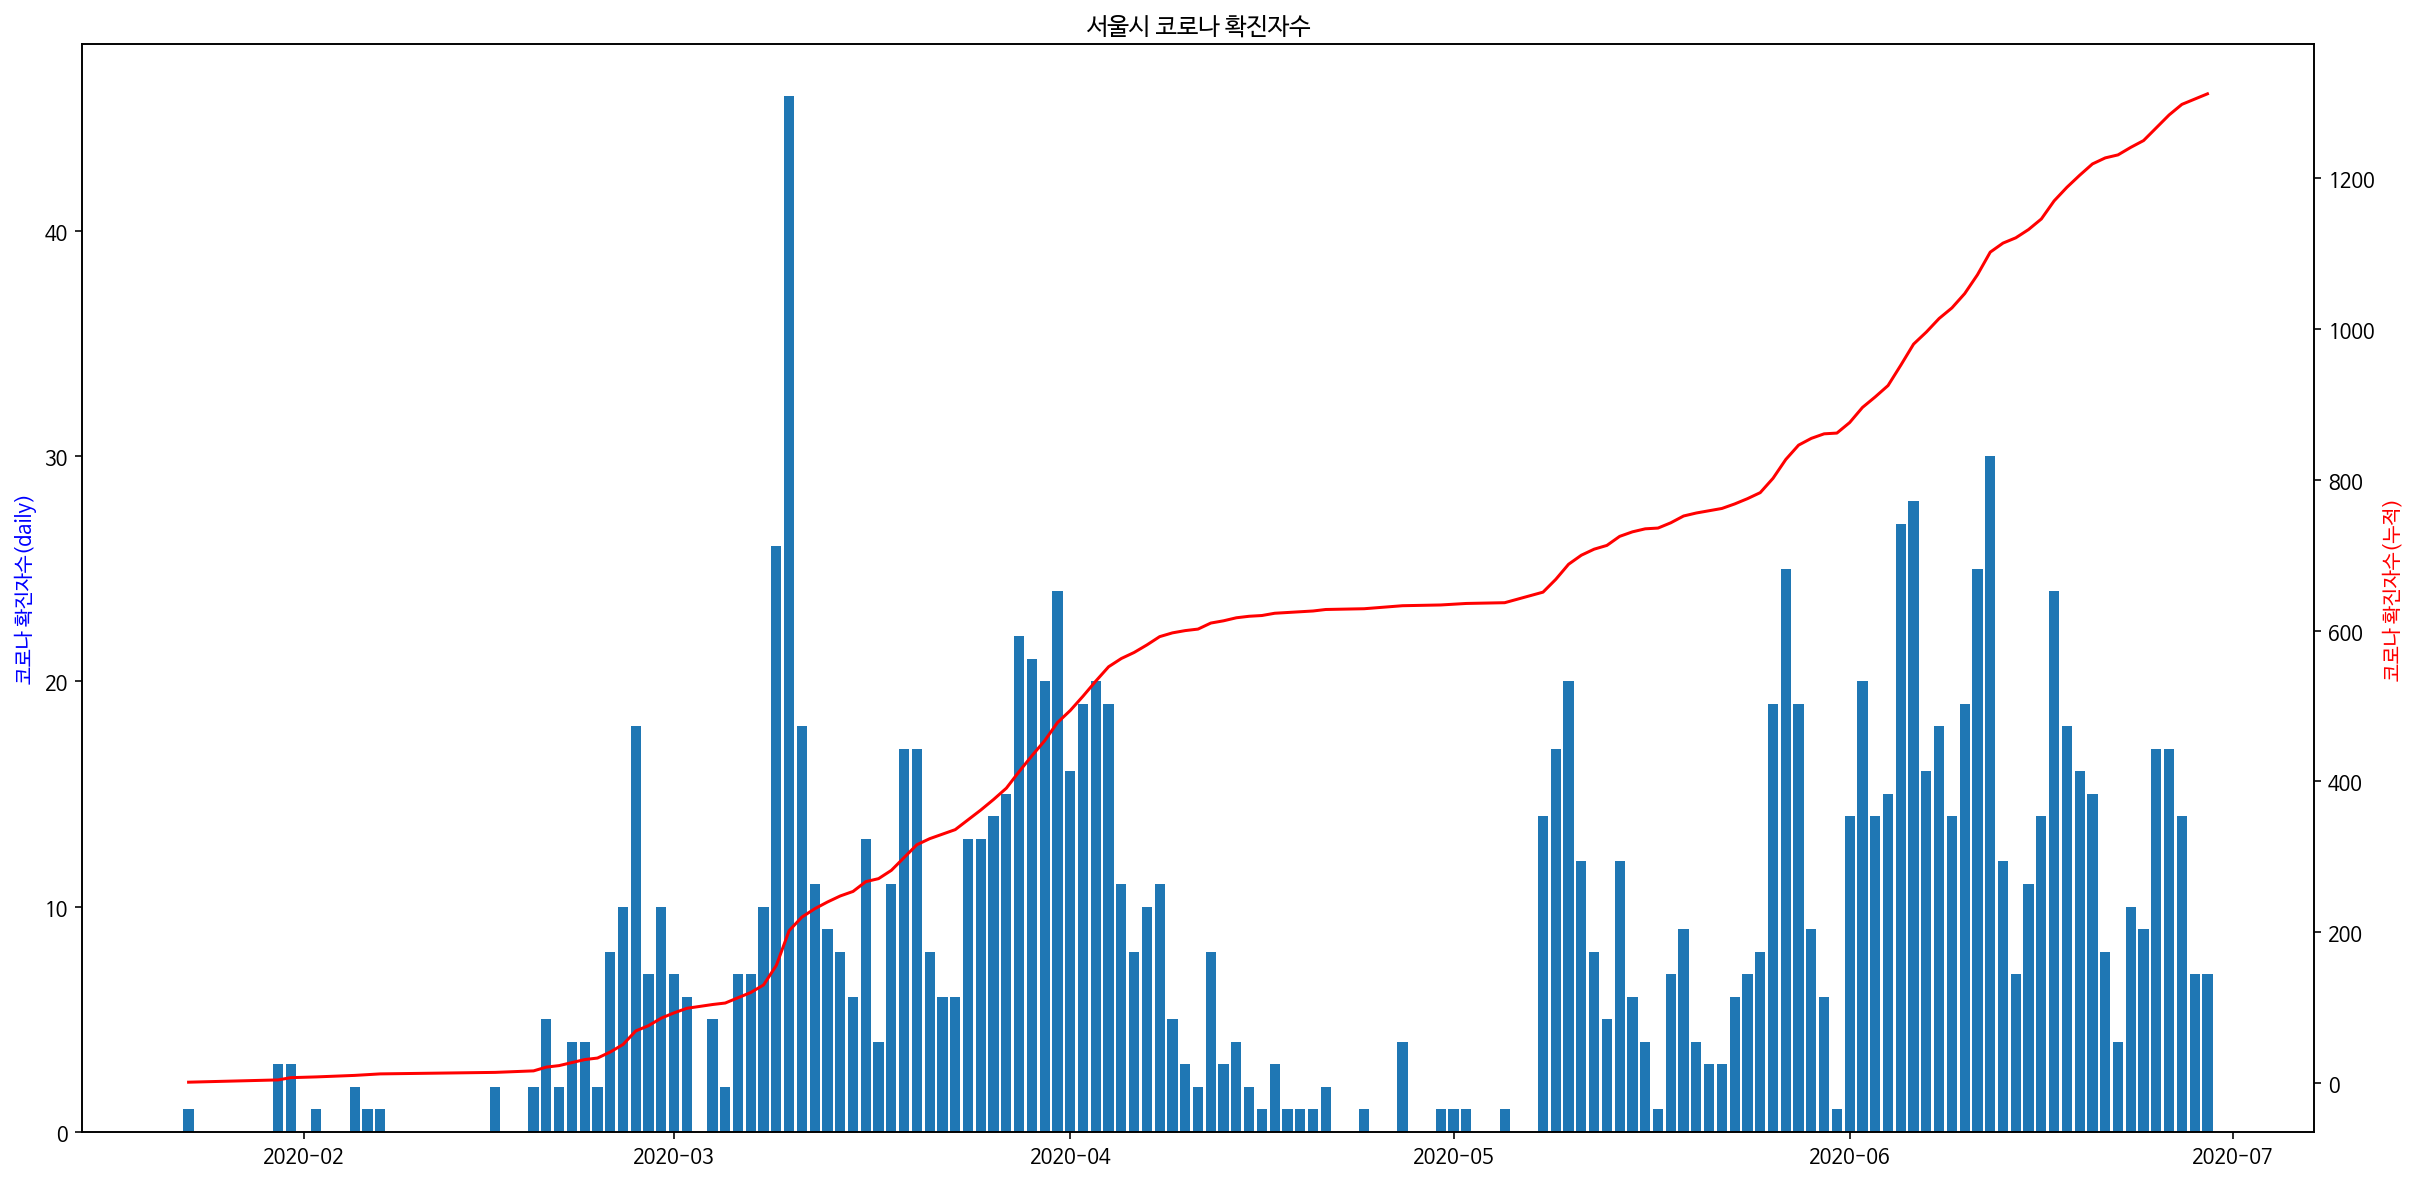

In [78]:
fig,ax1=plt.subplots(figsize=(20, 10))

ax2=ax1.twinx()
ax1.bar(patient_s['confirmed_date'],patient_s['cnt'])
ax2.plot(patient_s['confirmed_date'],patient_s['cnt_sum'],color='r')

ax1.set_label('date')
ax1.set_ylabel('코로나 확진자수(daily)',color='b')
ax2.set_ylabel('코로나 확진자수(누적)', color='r')

plt.title('서울시 코로나 확진자수')

plt.show()

이후 진행할 분석에서 포스트 코로나로 판단할 시점을 찾기 위해 서울의 월별 신규 확진자 수를 확인하였습니다.  
전국 분포를 봤을 때 언급한 바와 같이 1,2월에 비해 3월에 확진자 수가 급증하였으며 거리두기 캠페인이 종료된 이후 점차 급증함을 보였습니다.


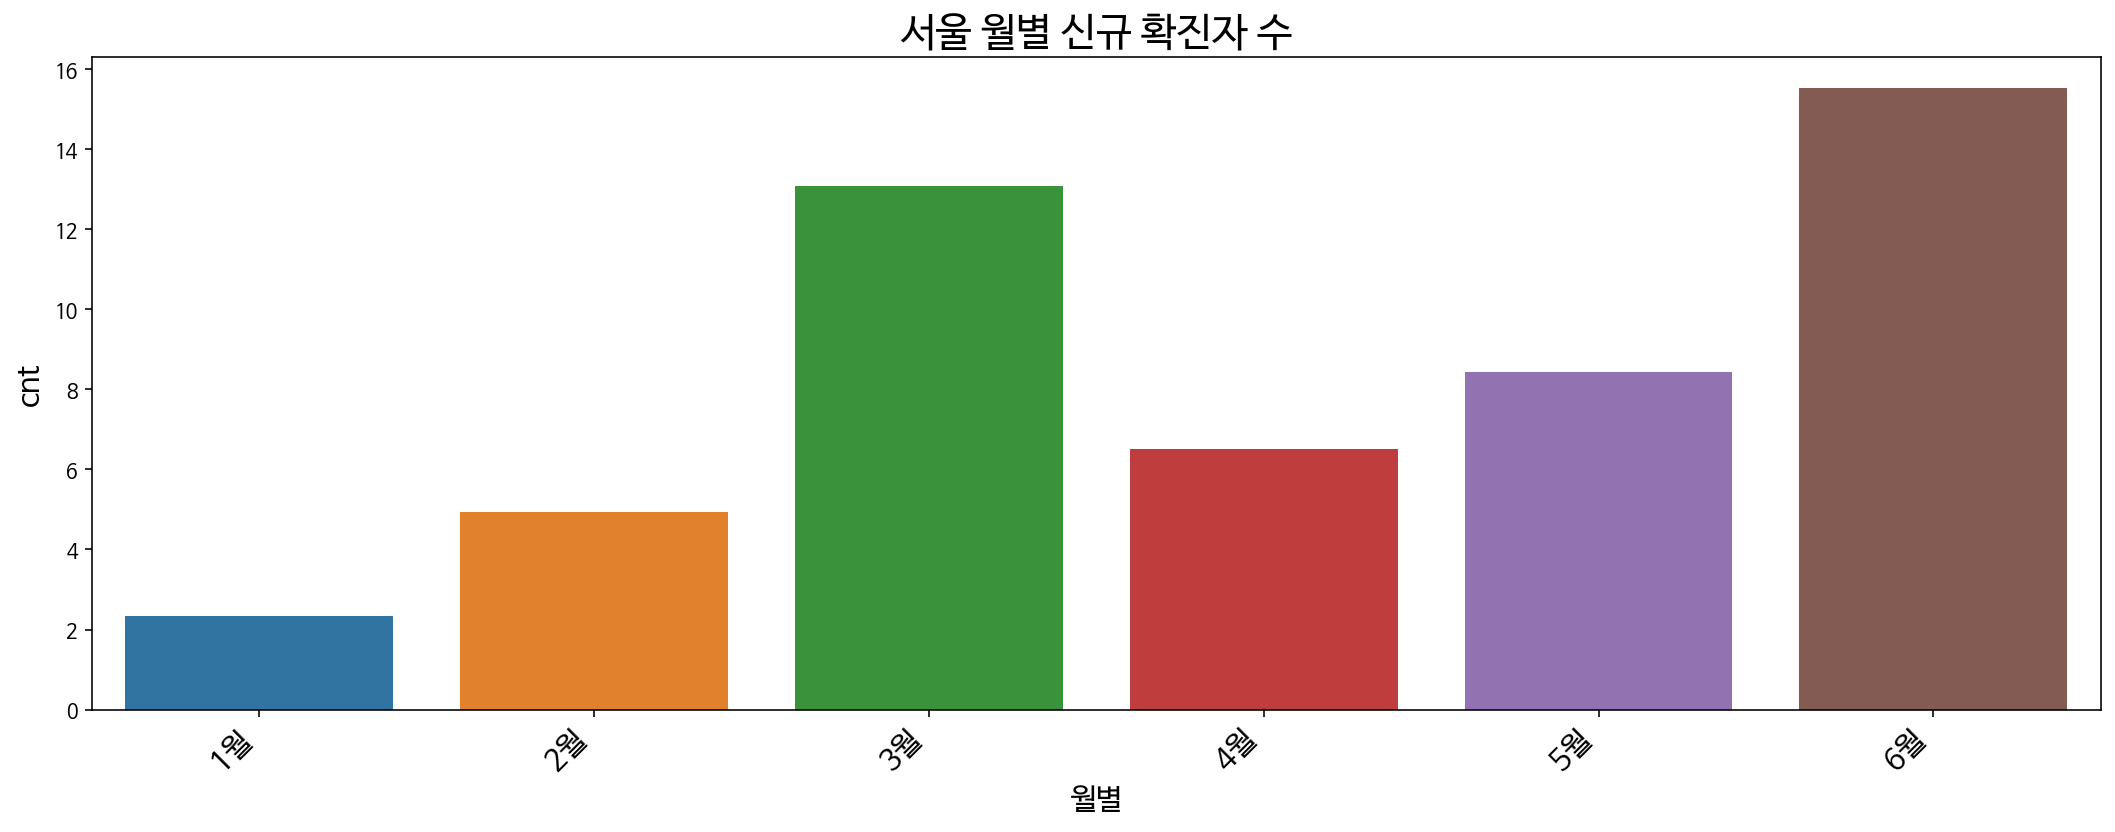

In [74]:
plt.figure(figsize=(18, 6))
pal = sns.color_palette("Blues_d", patient_s.shape[0])
sns.barplot(data=patient_s, x='월', y='cnt',ci=None)


plt.title(f'서울 월별 신규 확진자 수', size=20)
plt.xticks(rotation=45, size=15, ha='right')
plt.xlabel('월별', size=15)
plt.ylabel('cnt', size=15)
plt.show()

좀 더 구체적인 시점을 찾기 위해 주단위로 데이터를 비교해본 결과, 확진자 수가 급증한 시점은 9주차로 볼 수 있습니다. 구체적인 일자는 일별 확진자수를 비교하여 결정하였으며, 그 결과 20년도 3월 10일까지는 코로나 이전의 시대, 3월 11일부터는 포스트 코로나 시대로 분류하도록 하였습니다.

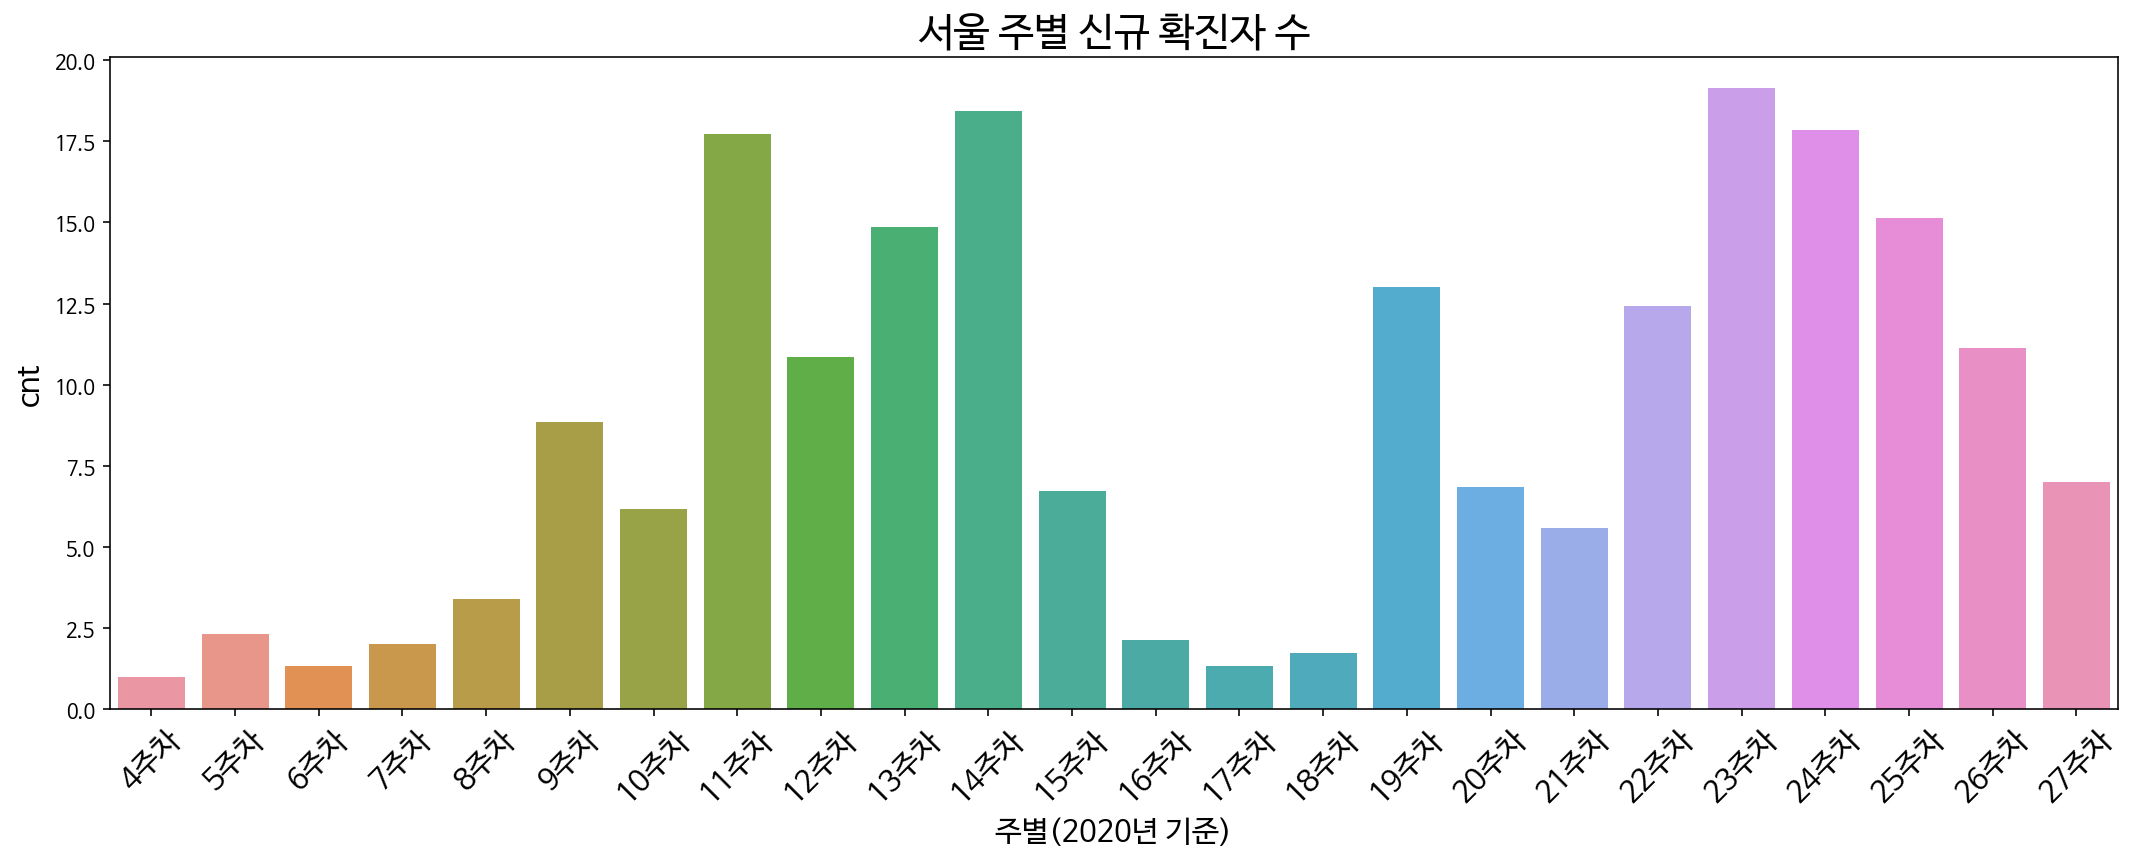

In [75]:

plt.figure(figsize=(18, 6))
"""pal = sns.color_palette("Blues_d", patient_s.shape[0])
rank = patient_s['cnt'].argsort().argsort()"""
sns.barplot(data=patient_s, x='주차', y='cnt',ci=None)

"""plt.axvline(7, color='red', label='포스트코로나 시작 시점')
plt.axvspan(7, 26.5, facecolor='red', alpha=0.1)
plt.legend(fontsize=15)"""

plt.title(f'서울 주별 신규 확진자 수', size=20)
plt.xticks(rotation=45, size=15)
plt.xlabel('주별(2020년 기준)', size=15)
plt.ylabel('cnt', size=15)
plt.show()


In [31]:
fpopl=pd.read_csv('/content/gdrive/My Drive/dacon/fpopl.csv',usecols=['base_ymd','adstrd_code','popltn_cascnt'])

날짜별 유동인구 수

fpopl_b : 코로나 확산 이전, fpopl_a : 코로나 확신이후

In [32]:
is_day=fpopl['base_ymd']<20200311
fpopl_b=fpopl[is_day]
fpopl_b.tail()

,base_ymd,adstrd_code,popltn_cascnt
19796789,20200310,11320670,48
19796790,20200310,11380520,22
19796791,20200310,11470610,8
19796792,20200310,11500535,52
19796793,20200310,11560700,22


In [33]:
fpopl_b['adstrd_code']=fpopl_b['adstrd_code'].astype(str)
fpopl_b['adstrd_code'] = fpopl_b['adstrd_code'].apply(lambda x:x[:5])

In [34]:
fpopl_b=fpopl_b.groupby(by=['adstrd_code'],as_index=False).popltn_cascnt.mean()

In [35]:
fpopl_a=fpopl.drop(fpopl[is_day].index)
fpopl_a['adstrd_code']=fpopl_a['adstrd_code'].astype(str)
fpopl_a['adstrd_code']=fpopl_a['adstrd_code'].apply(lambda x:x[:5])
fpopl_a=fpopl_a.groupby(by=['adstrd_code'],as_index=False).popltn_cascnt.mean()

In [36]:
add_2=[]
for i in range(len(fpopl_a)):
    add_2.append(fpopl_a['popltn_cascnt'][i])

fpopl_diff=fpopl_b
fpopl_diff['covid_after']=add_2

fpopl_diff.columns=['adstrd_code','covid_before','covid_after']

In [37]:
fpopl_diff['diff']=fpopl_diff['covid_before']-fpopl_diff['covid_after']
fpopl_diff=fpopl_diff.sort_values(by=['diff'],ascending=False)
fpopl_diff=fpopl_diff.reset_index()
fpopl_diff=fpopl_diff.drop(['index'],axis=1)

In [40]:
adstrd=pd.read_csv('/content/gdrive/My Drive/dacon/adstrd_master.csv')
adstrd['adstrd_code']=adstrd['adstrd_code'].astype(str)
adstrd['adstrd_code']=adstrd['adstrd_code'].apply(lambda x:x[:5])
adstrd['total_adstrd']=adstrd['brtc_nm']+' '+adstrd['signgu_nm']

adstrd_s=adstrd[adstrd['brtc_nm']=='서울특별시']
adstrd_s=adstrd_s[['adstrd_code','total_adstrd']]

In [41]:
adstrd_s=adstrd_s.drop_duplicates(['adstrd_code'],keep='first')
adstrd_s=adstrd_s.reset_index()
adstrd_s=adstrd_s.drop(['index'],axis=1)
adstrd_s.head(10)

,adstrd_code,total_adstrd
0,11110,서울특별시 종로구
1,11140,서울특별시 중구
2,11170,서울특별시 용산구
3,11200,서울특별시 성동구
4,11215,서울특별시 광진구
5,11230,서울특별시 동대문구
6,11260,서울특별시 중랑구
7,11290,서울특별시 성북구
8,11305,서울특별시 강북구
9,11320,서울특별시 도봉구


코로나 확산 이전/이후 유동인구변화 값

In [42]:
adstrd_nm=dict()
for i in range(len(adstrd_s)):
    adstrd_nm[adstrd_s['adstrd_code'][i]]=adstrd_s['total_adstrd'][i]
  
ad_name=[]
for i in range(len(fpopl_diff)):
    ad_name.append(adstrd_nm[fpopl_diff['adstrd_code'][i]])
fpopl_diff['adstrd_name']=ad_name

In [43]:
fpopl_diff=fpopl_diff.sort_values(by=['adstrd_name'],ascending=False)
fpopl_diff=fpopl_diff.reset_index()
fpopl_diff=fpopl_diff.drop(['index'],axis=1)

In [48]:
region=pd.read_csv('/content/gdrive/My Drive/dacon/COVID_19/Region.csv',usecols=['province','city','latitude','longitude'])
region_seoul=region[region['province']=='서울']
region_seoul['province']='서울특별시'
region_seoul['total_ads']=region_seoul['province']+' '+region_seoul['city']
region_s=region_seoul[['total_ads','latitude','longitude']]
region_s=region_s[1:]
region_s=region_s.reset_index()
region_s=region_s.drop(['index'],axis=1)
region_s=region_s.sort_values(by=['total_ads'],ascending=False)
region_s=region_s.reset_index()
region_s=region_s.drop(['index'],axis=1)

In [49]:
ad_lat=[]
ad_lon=[]
for i in range(len(region_s)):
    ad_lat.append(region_s['latitude'][i])
for i in range(len(region_s)):
    ad_lon.append(region_s['longitude'][i])

fpopl_diff['latitude']=ad_lat
fpopl_diff['longitude']=ad_lon

코로나 발생 전과 후의 유동인구의 변화와 확진자 수 간의 관계를 비교하기 위해 데이터를 지도로 시각화하였습니다.
먼저 각 구별 코로나 이전의 유동인구수 평균과 이후의 유동인구수 평균을 계산하였고, 그 차이를 diff값으로 하였습니다.

In [88]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
        
import seaborn as sns
import matplotlib.pyplot as plt

import folium 
from folium import plugins
# from folium.plugins import HeatMap

import json 
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import webbrowser

In [79]:
fpopl_diff=fpopl_diff.sort_values(by=['diff'],ascending=False)
fpopl_diff.head()

,adstrd_code,covid_before,covid_after,diff,adstrd_name,latitude,longitude
4,11170,218.085938,196.987985,21.097953,서울특별시 용산구,37.532768,126.990021
10,11650,317.802200,302.648947,15.153254,서울특별시 서초구,37.483804,127.032693
18,11530,189.388577,175.724644,13.663933,서울특별시 구로구,37.495632,126.887650
1,11140,184.023932,176.336182,7.687749,서울특별시 중구,37.563988,126.997530
5,11560,236.304922,233.458827,2.846095,서울특별시 영등포구,37.526505,126.896190


In [82]:
state_geo2 ='/content/gdrive/My Drive/dacon/sigungu/TL_SIG_WGS84.json'

In [89]:
m = folium.Map(location=[37.55, 127], tiles="OpenStreetMap", zoom_start=10)
# Add the color for the chloropleth:

m.choropleth(
 geo_data=state_geo2,
 name='diff',
 data=fpopl_diff,
 columns=['adstrd_code', 'diff'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population diff'
)
    

plugins.Fullscreen(position='topright',  # Full screen
                   title='Click to Expand', 
                   title_cancel='Click to Exit', 
                   force_separate_button=True).add_to(m)

plugins.MousePosition().add_to(m) ## you can easily get coordinates.

m


UnicodeDecodeError: ignored